# IS-BQPhy-Optimization-Proj-F25 Notebook

In [230]:
from typing import List, Tuple

import numpy as np
import bqphy.BQPhy_Optimiser as qea

In [231]:
# ------------------------ PROBLEM-SPECIFIC: Portfolio Data ------------------------ #
# --- REAL DATA (PROBLEM-SPECIFIC) ---

# Data is taken from: https://etfdb.com/compare/market-cap/#:~:text=VOO%20%2079%24823%2C286%2C000,00%2016%2C286%2C791

# Expected returns per $1 invested (decimal)
arrExpectedReturns = np.array([
    0.09, 0.09, 0.09, 0.09, 0.11, 0.10, 0.07, 0.06, 0.08, 0.05,
    0.04, 0.05, 0.10, 0.09, 0.08, 0.12, 0.09, 0.08, 0.08, 0.09,
    0.12, 0.09, 0.10, 0.09, 0.10
], dtype=float)

# Standard deviations (volatility) per asset (PROBLEM-SPECIFIC)
arrVolatilities = np.array([
    0.15, 0.15, 0.15, 0.16, 0.20, 0.18, 0.16, 0.16, 0.14, 0.05,
    0.15, 0.05, 0.18, 0.22, 0.18, 0.21, 0.22, 0.18, 0.11, 0.15,
    0.21, 0.18, 0.22, 0.16, 0.17
], dtype=float)

# Price per share (PROBLEM-SPECIFIC)
arrPrices = np.array([
    430, 460, 465, 240, 400, 350, 50, 70, 150, 72,
    180, 100, 320, 50, 60, 500, 40, 250, 170, 55,
    200, 230, 110, 100, 160
], dtype=float)

arrTicker = np.array([
    "VOO", "IVV", "SPY", "VTI", "QQQ", "VUG", "VEA", 
    "IEFA", "VTV", "BND", "GLD", "AGG", "IWF", "IEMG", 
    "VXUS", "VGT", "VWO", "IJH", "VIG", "SPYM", "XLK", 
    "VO", "IJR", "ITOT", "RSP", "BNDX", "IWM", "SCHD", 
    "IBIT", "QQQM"
])

arrDescriptions = np.array([
    "Vanguard S&P 500 ETF (U.S. large‑cap)", 
    "iShares Core S&P 500 ETF", 
    "SPDR S&P 500 ETF Trust", 
    "Vanguard Total Stock Market ETF", 
    "Invesco QQQ Trust Series I (NASDAQ‑100)", 
    "Vanguard Growth ETF", 
    "Vanguard FTSE Developed Markets ETF", 
    "iShares Core MSCI EAFE ETF", 
    "Vanguard Value ETF", 
    "Vanguard Total Bond Market ETF", 
    "SPDR Gold Shares", 
    "iShares Core U.S. Aggregate Bond ETF", 
    "iShares Russell 1000 Growth ETF", 
    "iShares Core MSCI Emerging Markets ETF", 
    "Vanguard Total International Stock ETF", 
    "Vanguard Information Technology ETF", 
    "Vanguard FTSE Emerging Markets ETF", 
    "iShares Core S&P Mid‑Cap ETF", 
    "Vanguard Dividend Appreciation ETF", 
    "SPDR Portfolio S&P 500 ETF (low‑cost)", 
    "Technology Select Sector SPDR ETF", 
    "Vanguard Mid‑Cap ETF", 
    "iShares Core S&P Small‑Cap ETF", 
    "iShares Core S&P Total U.S. Stock Market ETF", 
    "Invesco S&P 500 Equal Weight ETF", 
    "Vanguard Total International Bond ETF", 
    "iShares Russell 2000 ETF", 
    "Schwab U.S. Dividend Equity ETF", 
    "iShares Bitcoin Trust ETF", 
    "Invesco NASDAQ‑100 ETF"
], dtype=str)

NUM_ASSETS = arrExpectedReturns.shape[0]

In [232]:
# Preferences / constraints (PROBLEM-SPECIFIC)
availableCapital = 1000.0          # hard capital limit
preferred_min_stocks = 5          # soft diversification lower bound
preferred_max_stocks = 15         # soft diversification upper bound

In [233]:
# Objective/Fitness function parameters (MODEL-SPECIFIC / tunable)
lambda_risk = .35                 # risk aversion multiplier
hard_violation_penalty = 1e6      # very large to enforce hard constraints
under_diversification_penalty = 10.0         # penalty per missing stock if under-diversified
over_diversification_penalty = 5.0        # penalty per extra stock if over-diversified

In [234]:
# ------------------------ FITNESS FUNCTION (vectorized) ------------------------ #
def portfolio_fitness(x):
  """
  Vectorized fitness function for BQPhy optimizer.
  Accepts:
  - 1D numpy array of length NUM_ASSETS (single candidate)
  - OR 2D numpy array shape (population_size, NUM_ASSETS)

  Returns:
  - scalar fitness (if input 1D) or 1D array of fitness values (if input 2D)
  Fitness is minimized by BQPhy.
  """

  # ------------------------  Data Preprocessing ------------------------ #

  # Normalize input to 2D for unified processing
  arr = np.array(x, dtype=float)
  single = False
  if arr.ndim == 1:
    arr = arr.reshape(1, -1)
    single = True

  int_arr = np.floor(arr).astype(int)  # Ensures discretization

  # ------------------------  Objective Function ------------------------ #

  # Calculate objective function components
  expected_returns = int_arr @ arrExpectedReturns
  variances = int_arr @ (arrVolatilities ** 2)  # Using diagonal approximation
  total_investments = int_arr @ arrPrices     
  num_selected = np.sum(int_arr > 0.0, axis=1)

  # Caulcate objective function values
  objective_vals = expected_returns - lambda_risk * variances  

  # ------------------------ HARD CONSTRAINTS ------------------------ #

  # HC1 - Impossible to invest more than you have
  violation1 = np.maximum(total_investments - availableCapital, 0.0)

  # HC2 - Must invest something
  violation2 = (total_investments <= 0.0)

  # HC3 - No shorting
  violation3 = np.maximum(-np.minimum(arr, 0.0).sum(axis=1), 0.0)  # sum negative parts

  # ------------------------ SOFT CONSTRAINTS ------------------------ #

  # SC1 - Penalize Insufficient Diversification
  soft_penalty1 = np.maximum(preferred_min_stocks - num_selected, 0.0)

  # SC2 - Penalize Over-Diversification
  soft_penalty2 = np.maximum(num_selected - preferred_max_stocks, 0.0)

  # ------------------------ FITNESS FUNCTION ------------------------ #
  fitness = -objective_vals.copy() * 1e5
  fitness += violation1.astype(float) * hard_violation_penalty
  fitness += violation2.astype(float) * hard_violation_penalty
  fitness += violation3.astype(float) * hard_violation_penalty
  fitness += soft_penalty1 * under_diversification_penalty
  fitness += soft_penalty2 * over_diversification_penalty

  # If single input, return scalar
  if single:
    return float(fitness[0])
  return fitness  # numpy array


In [235]:
# ------------------------ HELPER: compute portfolio summary ------------------------ #
def compute_portfolio_summary(solution: np.ndarray) -> Tuple[float, float, float, str]:
    """
    Compute portfolio return, volatility, total investment, and CSV of tickers bought.
    """
    sol = np.floor(np.array(solution, dtype=float)).astype(int)
    sol = np.maximum(sol, 0)
    selected_idx = np.where(sol > 0)[0]

    total_investment = float(np.sum(sol[selected_idx] * arrPrices[selected_idx]))
    weights = (sol[selected_idx] * arrPrices[selected_idx]) / total_investment
    portfolio_return = float(np.sum(weights * arrExpectedReturns[selected_idx]))
    portfolio_variance = float(np.sum((weights ** 2) * (arrVolatilities[selected_idx] ** 2)))
    portfolio_volatility = portfolio_variance ** 0.5

    bought_csv = ", ".join([f"{arrTicker[i]}x{sol[i]}" for i in selected_idx])

    return portfolio_return, total_investment, portfolio_volatility, bought_csv


In [236]:
# ------------------------ RUN A SINGLE TRIAL ------------------------ #
def run_single_optimization_trial():

    # --- helper to ensure fitness is always scalar when returned ---
    def fitness_to_scalar(f):
        """
        Safely convert any fitness (float, list, numpy array, etc.)
        into a scalar float for ranking.
        """
        try:
            return float(f)
        except Exception:
            pass

        try:
            import numpy as np
            arr = np.asarray(f).astype(float)
            return float(arr.ravel()[0])
        except Exception:
            return float("inf")  # fallback for un-sortable objects

    # Compute Upper Bound on an asset-specific basis
    max_shares_arr = np.floor(availableCapital / arrPrices).astype(int)


    # BQPhy configuration
    config = {
        "numPopulation": 500, # tunable
        "maxGeneration": 200, # tunable
        "deltaTheta": 0.005, # tunable
        "designVariables": NUM_ASSETS, # Fixed
        "typeOfOptimisation": "CONTINUOUS",
        "lowerBounds": [0.0] * NUM_ASSETS,
        "upperBounds":  max_shares_arr.tolist() 
    }

    # Initialize and configure optimizer
    optimizer = qea.BQPhy_OPTIMISER()
    optimizer.initialize(config)

    # Register model (fitness function)
    optimizer.model(portfolio_fitness)

    # Run optimization (backend)
    optimizer.runOptimization("openmp")

    # Retrieve best design
    best_solution, best_fitness = optimizer.getBestDesign()

    pr, inv, vol, bought = compute_portfolio_summary(best_solution)
    best_fitness_scalar = fitness_to_scalar(best_fitness)

    return {
        "solution": best_solution,
        "fitness": best_fitness_scalar,   # << safe
        "return": pr,
        "investment": inv,
        "volatility": vol,
        "bought": bought
    }


In [237]:
# ------------------------ MAIN  ------------------------ #
def main(num_trials: int = 20):
    print("\n\nBQPhy Portfolio Optimization - Real Data & Discrete Continuous Portfolios\n")
    print("" + "=" * 60)

    # Data Summary
    print("Input Data Summary\n")
    for i in range(NUM_ASSETS):
        print(f"{arrTicker[i]} - {arrDescriptions[i]}")
        print(f"   price=${arrPrices[i]:.2f}, expected_return={arrExpectedReturns[i]:.3f}, volatility={arrVolatilities[i]:.3f}")

    print(f"\nAvailable capital: ${availableCapital:.2f}")
    print(f"Preferred diversification: {preferred_min_stocks} - {preferred_max_stocks} assets\n")
    print("" + "=" * 60)
    print("\n")

    all_trials = []

    for t in range(1, num_trials + 1):
        print(f"\nTrial {t}:")
        result = run_single_optimization_trial()
        all_trials.append(result)
        fitness_score = portfolio_fitness(result["solution"]) # Recalculation

        print(f"  Fitness (BQPhy): {result['fitness']:.6f}")
        print(f"  Fitness (Calculated): {fitness_score:.6f}")
        print(f"  Total Investment: ${result['investment']:.2f}")
        print(f"  Portfolio Expected Return: {result['return']*100:.2f}%")
        print(f"  Portfolio Volatility: {result['volatility']*100:.2f}%")
        print(f"  Number of Assets Selected: {len(result['bought'].split(', '))}")
        print(f"  Bought: {result['bought']}")

    # ------------------------ OVERALL SUMMARY ------------------------ #
    print("\n\n==================== OVERALL SUMMARY ====================")

    # Rank portfolios by fitness (lower fitness = better)
    ranked = sorted(enumerate(all_trials, 1), key=lambda x: x[1]["fitness"])
    best_trial_num, best = ranked[0]
    best_calc_fitness = portfolio_fitness(best["solution"])

    print(f"\nBest Portfolio:")
    print(f"  Trial {best_trial_num}")
    print(f"  Fitness (BQPhy): {best['fitness']:.6f}")
    print(f"  Fitness (Calculated): {best_calc_fitness:.6f}")
    print(f"  Total Investment: ${best['investment']:.2f}")
    print(f"  Portfolio Return: {best['return']*100:.2f}%")
    print(f"  Portfolio Volatility: {best['volatility']*100:.2f}%")
    print(f"  Number of Assets Selected: {len(best['bought'].split(', '))}")
    print(f"  Bought: {best['bought']}")

    print("\nAverage Metrics Across All Trials:")

    avg_inv = np.mean([t["investment"] for t in all_trials])
    avg_ret = np.mean([t["return"] for t in all_trials])
    avg_vol = np.mean([t["volatility"] for t in all_trials])
    avg_num_assets = np.mean([len(t["bought"].split(", ")) if t["bought"] else 0 for t in all_trials])

    print(f"  Avg. Total Investment: ${avg_inv:.2f}")
    print(f"  Avg. Portfolio Return: {avg_ret*100:.2f}%")
    print(f"  Avg. Portfolio Volatility: {avg_vol*100:.2f}%")
    print(f"  Avg. Number of Assets Selected: {avg_num_assets:.2f}\n")

    print("=" * 62)

    globals()["last_trials"] = all_trials
    return all_trials



In [238]:
last_trials = main()




BQPhy Portfolio Optimization - Real Data & Discrete Continuous Portfolios

Input Data Summary

VOO - Vanguard S&P 500 ETF (U.S. large‑cap)
   price=$430.00, expected_return=0.090, volatility=0.150
IVV - iShares Core S&P 500 ETF
   price=$460.00, expected_return=0.090, volatility=0.150
SPY - SPDR S&P 500 ETF Trust
   price=$465.00, expected_return=0.090, volatility=0.150
VTI - Vanguard Total Stock Market ETF
   price=$240.00, expected_return=0.090, volatility=0.160
QQQ - Invesco QQQ Trust Series I (NASDAQ‑100)
   price=$400.00, expected_return=0.110, volatility=0.200
VUG - Vanguard Growth ETF
   price=$350.00, expected_return=0.100, volatility=0.180
VEA - Vanguard FTSE Developed Markets ETF
   price=$50.00, expected_return=0.070, volatility=0.160
IEFA - iShares Core MSCI EAFE ETF
   price=$70.00, expected_return=0.060, volatility=0.160
VTV - Vanguard Value ETF
   price=$150.00, expected_return=0.080, volatility=0.140
BND - Vanguard Total Bond Market ETF
   price=$72.00, expected_retur

In [239]:
import matplotlib.pyplot as plt
from collections import Counter

# Trials to run if no cached run is available from main()
viz_trials = 10

# Reuse the last main() run if it exists
try:
    base_records = list(last_trials)
    print(f"Using {len(base_records)} trial(s) cached from main().")
except Exception:
    base_records = []

if not base_records:
    print(f"No cached trials found; running {viz_trials} fresh trial(s) for visualization.")
    base_records = []
    for t in range(1, viz_trials + 1):
        res = run_single_optimization_trial()
        res["trial"] = t
        base_records.append(res)

if not base_records:
    raise RuntimeError("No trial results available; rerun this cell after running main().")

# Normalize/augment fields for plotting and tables
viz_records = []
for idx, rec in enumerate(base_records, start=1):
    item = dict(rec)
    item["trial"] = rec.get("trial", idx)
    item["num_assets"] = len(rec.get("bought", "").split(", ")) if rec.get("bought") else 0
    viz_records.append(item)

try:
    import pandas as pd
    display(pd.DataFrame(viz_records).sort_values("fitness").head(5))
except Exception:
    print("Install pandas to see the sorted trial table; plots below still work.")


Using 20 trial(s) cached from main().


,solution,fitness,return,investment,volatility,bought,trial,num_assets
6,"[0.8245975432974746, 0.8780041199359121, 0.885...",3.289682e+09,0.088247,787.0,0.089178,"IEFAx1, BNDx1, IEMGx3, VXUSx4, SPYMx1, XLKx1",7,6
10,"[0.4994583047226673, 0.4153505760280767, 0.709...",3.804753e+09,0.073316,965.0,0.080447,"VEAx5, IEFAx5, IEMGx2, VXUSx1, VWOx1, SPYMx3",11,6
11,"[0.07891966124971384, 0.6236362249179828, 0.00...",3.903654e+09,0.079823,1073.0,0.066456,"IEFAx1, BNDx4, IEMGx5, VWOx1, SPYMx1, IJRx1, I...",12,8
4,"[0.49793240253299764, 0.7014877546349279, 0.64...",4.079686e+09,0.082403,932.0,0.061571,"VEAx1, IEFAx2, BNDx1, IEMGx2, VXUSx1, VWOx1, S...",5,9
5,"[0.2069428549629968, 0.8957656214236667, 0.534...",4.096628e+09,0.084900,851.0,0.075304,"BNDx3, IEMGx1, SPYMx1, IJRx1, ITOTx1, RSPx2",6,6


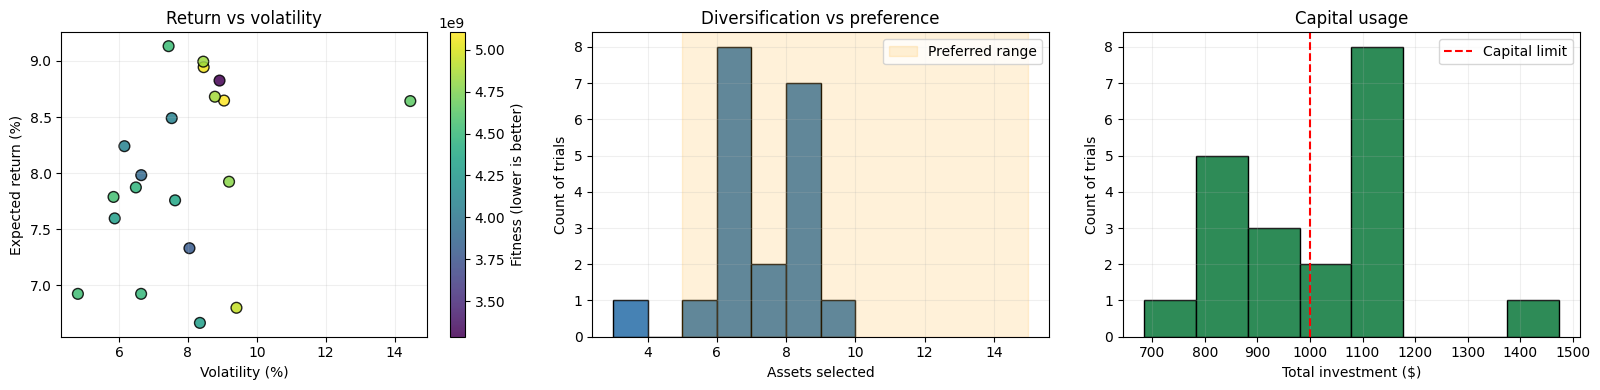

In [240]:
if not viz_records:
    raise RuntimeError("No trial data to plot; run the setup cell first.")

returns = [r["return"] * 100 for r in viz_records]
vols = [r["volatility"] * 100 for r in viz_records]
fitness_vals = [r["fitness"] for r in viz_records]
investments = [r["investment"] for r in viz_records]
num_assets = [r["num_assets"] for r in viz_records]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sc = axes[0].scatter(vols, returns, c=fitness_vals, cmap="viridis", s=60, edgecolor="k", alpha=0.85)
axes[0].set_xlabel("Volatility (%)")
axes[0].set_ylabel("Expected return (%)")
axes[0].set_title("Return vs volatility")
fig.colorbar(sc, ax=axes[0], label="Fitness (lower is better)")
axes[0].grid(alpha=0.2)

bins_assets = range(min(num_assets), max(num_assets) + 2)
axes[1].hist(num_assets, bins=bins_assets, color="steelblue", edgecolor="black")
axes[1].axvspan(preferred_min_stocks, preferred_max_stocks, color="orange", alpha=0.15, label="Preferred range")
axes[1].set_xlabel("Assets selected")
axes[1].set_ylabel("Count of trials")
axes[1].set_title("Diversification vs preference")
axes[1].legend()
axes[1].grid(alpha=0.2)

axes[2].hist(investments, bins=8, color="seagreen", edgecolor="black")
axes[2].axvline(availableCapital, color="red", linestyle="--", label="Capital limit")
axes[2].set_xlabel("Total investment ($)")
axes[2].set_ylabel("Count of trials")
axes[2].set_title("Capital usage")
axes[2].legend()
axes[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()


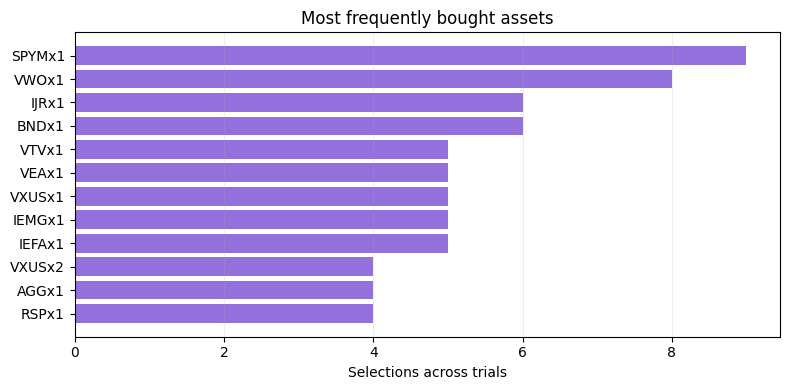

In [241]:
if not viz_records:
    raise RuntimeError("No trial data to plot; run the setup cell first.")

counts = Counter()
for rec in viz_records:
    tickers = rec.get("bought") or ""
    counts.update([t.strip() for t in tickers.split(",") if t.strip()])

common = counts.most_common(12)
if not common:
    print("No assets were selected in the sampled trials.")
else:
    labels, values = zip(*common)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(labels[::-1], values[::-1], color="mediumpurple")
    ax.set_xlabel("Selections across trials")
    ax.set_title("Most frequently bought assets")
    ax.grid(axis="x", alpha=0.2)
    plt.tight_layout()
    plt.show()
